# YouTube NLP

## Ingesting Comments from the YouTube Video

In [1]:
api_key = ''

In [2]:
from googleapiclient.discovery import build

# The string after v=? in the url
video_id = "dQw4w9WgXcQ"

# creating youtube resource object
youtube = build('youtube', 'v3',
developerKey=api_key)

# retrieve youtube video results
video_response=youtube.commentThreads().list(
  part='snippet',
  maxResults=1000,
  order='relevance',
  videoId=video_id
).execute()


## Data Preprocessing

### Data Wrangling

#### Assumptions


*   Picking only the comment made by the original author
  *   Comment Threads on the Original Authors comment could be diverging from the video
  *   Limiting Response to about 10 for testing

*   Using the 'textOriginal' instead of 'textDisplay' for easier cleanup of the comment


*   Analyzing only English Comments 
  *   Storing the number of non English comments for metrics








In [3]:
# empty list for storing reply
comments = []

# extracting required info from each result object
for item in video_response['items']:

  # Extracting comments
  comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
  # Extracting author
  author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
  # Extracting published time
  published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']
  # Extracting likes
  like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
  # Extracting total replies to the comment
  reply_count = item['snippet']['totalReplyCount']

  comments.append([author, comment, published_at, like_count, reply_count])

In [4]:
comments[0:5]

[['Rick Astley',
  '1 BILLION views for Never Gonna Give You Up!\xa0 Amazing, crazy, wonderful! Rick ♥️',
  '2021-07-28T21:00:32Z',
  1166470,
  497],
 ['H1K',
  "This isn't your first time here\nAnd you know it.",
  '2019-10-31T21:38:49Z',
  993653,
  494],
 ['Alain Flores',
  'Esta canción es genial,tanto tiempo y no ha Sido olvidada',
  '2023-01-02T16:48:50Z',
  210,
  12],
 ['Lukas',
  'Naah... temardo en verdad 😎🤙\r\n32707124 personas ya lo han escuchado,\r\nespero que te haya gustado 😉',
  '2023-01-02T16:26:56Z',
  239,
  4],
 ['breaking of the game 067',
  'Aparte de auto rickroll es muy buena fue un tema que no puede salir mas de su perfeccion fuera de los memes',
  '2023-01-02T20:58:42Z',
  45,
  1]]

### NLP

#### Install Libraries

In [5]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Text Processing

In [9]:
import pandas as pd
df = pd.DataFrame({'Author': [i[0] for i in comments], 'Comment': [i[1] for i in comments], 'Timestamp': [i[2] for i in comments],
                  'Likes': [i[3] for i in comments], 'TotalReplies': [i[4] for i in comments]})

In [10]:
df.head()

,Author,Comment,Timestamp,Likes,TotalReplies
0,Rick Astley,1 BILLION views for Never Gonna Give You Up! ...,2021-07-28T21:00:32Z,1166470,497
1,H1K,This isn't your first time here\nAnd you know it.,2019-10-31T21:38:49Z,993653,494
2,Alain Flores,"Esta canción es genial,tanto tiempo y no ha Si...",2023-01-02T16:48:50Z,210,12
3,Lukas,Naah... temardo en verdad 😎🤙\r\n32707124 perso...,2023-01-02T16:26:56Z,239,4
4,breaking of the game 067,Aparte de auto rickroll es muy buena fue un te...,2023-01-02T20:58:42Z,45,1


In [11]:
from cleantext import clean

# Remove extra spaces and make them lower case. Replace special emojis
clean_df = df
clean_df['Comment'] = clean_df['Comment'].apply(lambda x: x.strip().lower().replace('xd','').replace('<3',''))

# Clean text from line breaks, unicodes, emojis and punctuations
clean_df['Comment'] = clean_df['Comment'].apply(lambda x: clean(x, no_emoji=True, no_punct=True, no_line_breaks=True, fix_unicode=True))
clean_df.head()

,Author,Comment,Timestamp,Likes,TotalReplies
0,Rick Astley,1 billion views for never gonna give you up am...,2021-07-28T21:00:32Z,1166470,497
1,H1K,this isnt your first time here and you know it,2019-10-31T21:38:49Z,993653,494
2,Alain Flores,esta cancion es genialtanto tiempo y no ha sid...,2023-01-02T16:48:50Z,210,12
3,Lukas,naah temardo en verdad 32707124 personas ya lo...,2023-01-02T16:26:56Z,239,4
4,breaking of the game 067,aparte de auto rickroll es muy buena fue un te...,2023-01-02T20:58:42Z,45,1


In [12]:
from langdetect import detect
clean_df['Language'] = clean_df['Comment'].apply(lambda x: detect(x))
clean_df.head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language
0,Rick Astley,1 billion views for never gonna give you up am...,2021-07-28T21:00:32Z,1166470,497,en
1,H1K,this isnt your first time here and you know it,2019-10-31T21:38:49Z,993653,494,en
2,Alain Flores,esta cancion es genialtanto tiempo y no ha sid...,2023-01-02T16:48:50Z,210,12,es
3,Lukas,naah temardo en verdad 32707124 personas ya lo...,2023-01-02T16:26:56Z,239,4,es
4,breaking of the game 067,aparte de auto rickroll es muy buena fue un te...,2023-01-02T20:58:42Z,45,1,es


In [13]:
import pycountry
# Convert ISO country codes to Languages
clean_df['Language'] = clean_df['Language'].apply(lambda x: pycountry.languages.get(alpha_2=x).name)
clean_df.head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language
0,Rick Astley,1 billion views for never gonna give you up am...,2021-07-28T21:00:32Z,1166470,497,English
1,H1K,this isnt your first time here and you know it,2019-10-31T21:38:49Z,993653,494,English
2,Alain Flores,esta cancion es genialtanto tiempo y no ha sid...,2023-01-02T16:48:50Z,210,12,Spanish
3,Lukas,naah temardo en verdad 32707124 personas ya lo...,2023-01-02T16:26:56Z,239,4,Spanish
4,breaking of the game 067,aparte de auto rickroll es muy buena fue un te...,2023-01-02T20:58:42Z,45,1,Spanish


## Text Blob


In [25]:
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize
# New variable for TextBlob approach
textBlob = clean_df.loc[clean_df['Language']=='English']

def get_polarity(text):
  return TextBlob(text).sentiment.polarity

textBlob['TextBlob_Polarity'] = textBlob['Comment'].apply(get_polarity)

<ipython-input-25-423b311613ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textBlob['TextBlob_Polarity'] = textBlob['Comment'].apply(get_polarity)


In [26]:
textBlob['TextBlob_Sentiment_Type']=''
textBlob.loc[textBlob.TextBlob_Polarity>0,'TextBlob_Sentiment_Type']='POSITIVE'
textBlob.loc[textBlob.TextBlob_Polarity==0,'TextBlob_Sentiment_Type']='NEUTRAL'
textBlob.loc[textBlob.TextBlob_Polarity<0,'TextBlob_Sentiment_Type']='NEGATIVE'

<ipython-input-26-a2cc16ededd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textBlob['TextBlob_Sentiment_Type']=''
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [27]:
textBlob.TextBlob_Sentiment_Type.value_counts()

POSITIVE    33
NEUTRAL      8
NEGATIVE     4
Name: TextBlob_Sentiment_Type, dtype: int64

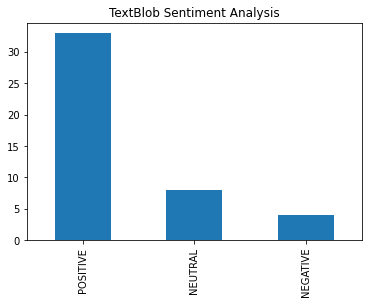

In [28]:
textBlob.TextBlob_Sentiment_Type.value_counts().plot(kind='bar',title="TextBlob Sentiment Analysis")

## Vader

In [36]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader_df = clean_df.loc[clean_df['Language']=='English']

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [37]:
vader_df['vader_scores'] = vader_df['Comment'].apply(lambda Comment: sid.polarity_scores(Comment))
vader_df.head()

<ipython-input-37-89412567477f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_df['vader_scores'] = vader_df['Comment'].apply(lambda Comment: sid.polarity_scores(Comment))


,Author,Comment,Timestamp,Likes,TotalReplies,Language,TextBlob_Polarity,TextBlob_Sentiment_Type,vader_scores,compound,vader_sentiment_type
0,Rick Astley,1 billion views for never gonna give you up am...,2021-07-28T21:00:32Z,1166470,497,English,0.333333,POSITIVE,"{'neg': 0.127, 'neu': 0.476, 'pos': 0.397, 'co...",0.7269,POSITIVE
1,H1K,this isnt your first time here and you know it,2019-10-31T21:38:49Z,993653,494,English,0.250000,POSITIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
6,Dylan,its come to the point that being rickrolled is...,2019-12-13T18:58:53Z,157770,490,English,0.000000,NEUTRAL,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.3612,POSITIVE
7,Space Shuttle Atlantis,memes aside even after 13 years this song stil...,2022-12-31T17:13:19Z,262,18,English,0.366667,POSITIVE,"{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'comp...",0.7650,POSITIVE
11,Amelia Honey,this has been the most amazing rick roll i hav...,2022-05-13T22:16:45Z,1111,45,English,0.550000,POSITIVE,"{'neg': 0.133, 'neu': 0.542, 'pos': 0.325, 'co...",0.5984,POSITIVE


In [38]:
vader_df['compound'] = vader_df['vader_scores'].apply(lambda score_dict: score_dict['compound'])
df['vader_sentiment_type']=''
df.loc[df.compound>0,'vader_sentiment_type']='POSITIVE'
df.loc[df.compound==0,'vader_sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'vader_sentiment_type']='NEGATIVE'

<ipython-input-38-6a0db8ea0467>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_df['compound'] = vader_df['vader_scores'].apply(lambda score_dict: score_dict['compound'])


In [39]:
vader_df.vader_sentiment_type.value_counts()

POSITIVE    24
NEUTRAL     16
NEGATIVE     5
Name: vader_sentiment_type, dtype: int64

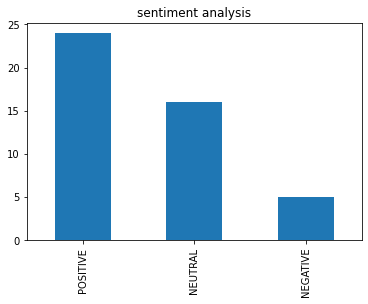

In [40]:
vader_df.vader_sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

## Comparison

In [35]:
vader_df.groupby(['vader_sentiment_type']).head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language,TextBlob_Polarity,TextBlob_Sentiment_Type,vader_scores,compound,vader_sentiment_type
0,Rick Astley,1 billion views for never gonna give you up am...,2021-07-28T21:00:32Z,1166470,497,English,0.333333,POSITIVE,"{'neg': 0.127, 'neu': 0.476, 'pos': 0.397, 'co...",0.7269,POSITIVE
1,H1K,this isnt your first time here and you know it,2019-10-31T21:38:49Z,993653,494,English,0.250000,POSITIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
6,Dylan,its come to the point that being rickrolled is...,2019-12-13T18:58:53Z,157770,490,English,0.000000,NEUTRAL,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.3612,POSITIVE
7,Space Shuttle Atlantis,memes aside even after 13 years this song stil...,2022-12-31T17:13:19Z,262,18,English,0.366667,POSITIVE,"{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'comp...",0.7650,POSITIVE
11,Amelia Honey,this has been the most amazing rick roll i hav...,2022-05-13T22:16:45Z,1111,45,English,0.550000,POSITIVE,"{'neg': 0.133, 'neu': 0.542, 'pos': 0.325, 'co...",0.5984,POSITIVE
14,Seanyie16,greatest music video the 90s ever saw,2023-01-01T15:58:01Z,67,13,English,1.000000,POSITIVE,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.6369,POSITIVE
16,dumb bee FBI edition,sometimes you just gotta rickroll yourself bec...,2019-07-23T06:54:55Z,143802,481,English,0.000000,NEUTRAL,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou...",-0.2960,NEGATIVE
25,Steven Giraldo,i definitely did not just get rick rolled shut...,2019-11-20T22:49:02Z,153058,494,English,0.000000,NEUTRAL,"{'neg': 0.175, 'neu': 0.649, 'pos': 0.175, 'co...",0.0000,NEUTRAL
26,Andreea Pa'Mi Bananeea,i hope that this person has no idea how famous...,2023-01-01T16:00:59Z,9,1,English,0.250000,POSITIVE,"{'neg': 0.214, 'neu': 0.607, 'pos': 0.179, 'co...",-0.0772,NEGATIVE
28,Dddf,the most legendary youtube video ever,2023-01-02T22:00:21Z,2,0,English,0.750000,POSITIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL


After the initial analysis and visual inspection. I think TextBlob is closer to the sentiment outcomes that I expect. Hence picking TextBlob for Sentiment analysis.

# DASHBOARD

A few insights that we draw:
1. Top 10 liked comments
2. Top 10 replies comments
3. World Cloud
4. Top languages commented in
5. Sentiment analysis on the English comments

## FUNCTIONS

In [41]:
url = 'https://www.youtube.com/watch?v=dQw4w9WgXcQ'

In [42]:
video_id = url.split('?v=')[-1]
video_id

'dQw4w9WgXcQ'

In [ ]:
from googleapiclient.discovery import build
import pandas as pd
from cleantext import clean
from langdetect import detect
import pycountry
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize

def get_polarity(text):
  return TextBlob(text).sentiment.polarity

def parse_video(url) -> pd.DataFrame:
  """
  Args:
    url: URL Of the video to be parsed 
  Returns:
    Dataframe with the processed and cleaned values
  """
  api_key = '{api_secret}'
  
  # Get the video_id from the url
  video_id = url.split('?v=')[-1]

  # creating youtube resource object
  youtube = build('youtube', 'v3',
  developerKey=api_key)

  # retrieve youtube video results
  video_response=youtube.commentThreads().list(
  part='snippet',
  maxResults=1000,
  order='relevance',
  videoId=video_id
  ).execute()

  # empty list for storing reply
  comments = []

  # extracting required info from each result object
  for item in video_response['items']:

    # Extracting comments
    comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
    # Extracting author
    author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
    # Extracting published time
    published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']
    # Extracting likes
    like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
    # Extracting total replies to the comment
    reply_count = item['snippet']['totalReplyCount']

    comments.append([author, comment, published_at, like_count, reply_count])
  
  df = pd.DataFrame({'Author': [i[0] for i in comments], 
                     'Comment': [i[1] for i in comments], 
                     'Timestamp': [i[2] for i in comments],
                  'Likes': [i[3] for i in comments], 
                  'TotalReplies': [i[4] for i in comments]})
  
  # Remove extra spaces and make them lower case. Replace special emojis
  df['Comment'] = df['Comment'].apply(lambda x: x.strip().lower().
                                      replace('xd','').replace('<3',''))

  # Clean text from line breaks, unicodes, emojis and punctuations
  df['Comment'] = df['Comment'].apply(lambda x: clean(x, 
                                                      no_emoji=True, 
                                                      no_punct=True,
                                                      no_line_breaks=True,
                                                      fix_unicode=True))
  
  # Detect the languages of the comments
  df['Language'] = df['Comment'].apply(lambda x: detect(x))

  # Convert ISO country codes to Languages
  df['Language'] = df['Language'].apply(lambda x: 
                                        pycountry.languages.get(alpha_2=x).name)
  
  # New variable for TextBlob approach
  textBlob = df.loc[df['Language']=='English']

  # Determining the polarity
  textBlob['TextBlob_Polarity'] = textBlob['Comment'].apply(get_polarity)

  textBlob['TextBlob_Sentiment_Type']=''
  textBlob.loc[textBlob.TextBlob_Polarity>0,'TextBlob_Sentiment_Type']='POSITIVE'
  textBlob.loc[textBlob.TextBlob_Polarity==0,'TextBlob_Sentiment_Type']='NEUTRAL'
  textBlob.loc[textBlob.TextBlob_Polarity<0,'TextBlob_Sentiment_Type']='NEGATIVE'

  return textBlob


## STREAMLIT

In [ ]:
pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 12.5 MB/s 
     |████████████████████████████████| 78 kB 9.8 MB/s 
     |████████████████████████████████| 184 kB 98.7 MB/s 
     |████████████████████████████████| 164 kB 110.5 MB/s 
     |████████████████████████████████| 238 kB 73.7 MB/s 
     |████████████████████████████████| 4.7 MB 91.3 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=ac67b45845245884379163a10abe7bd9eb05711afd9fe182422e8f17f4874d44
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [ ]:
pip install --upgrade protobuf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 15.3 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.12 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.
streamlit 1.16.0 requires protobuf<4,>=3.12, but you have protobuf 4.21.12 which is incompatible.


In [ ]:
import streamlit as st 
st.set_page_config(
    page_title="Real-Time Data Science Dashboard",
    page_icon="✅",
    layout="wide",
)
st.markdown("### Detailed Data View")
st.dataframe(clean_df)

  command:

    streamlit run /usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2023-01-03 03:14:57.253 
  command:

    streamlit run /usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [ ]:
!streamlit run /usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py



Traceback (most recent call last):
  File "/usr/local/bin/streamlit", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/streamlit/web/cli.py", line 206, in main_run
    _main_run(target, args, flag_options=kwargs)
  File "/usr/local/lib/python3.8/dist-packages/streamlit/web/cli.py", line 242, in _main_run
    bootstrap.run(file, 